In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class AlexNetPaper(nn.Module):
    def __init__(self, num_classes=1000, dropout=0.5):
        super().__init__()
        # --- Convolutional feature extractor ---
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # --- Fully connected classifier ---
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Create model instance
model = AlexNetPaper(num_classes=1000).to(device)

# Print model architecture summary
print(model)

AlexNetPaper(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequen

In [ ]:
# dummy input (like a single RGB image of 227x227)
x = torch.randn(1, 3, 227, 227).to(device)

# Forward pass to check output shape
out = model(x)
print("Output shape:", out.shape)

Output shape: torch.Size([1, 1000])


In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            # Gaussian (normal) initialization for Conv layers
            nn.init.normal_(m.weight, mean=0.0, std=0.01)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

        elif isinstance(m, nn.Linear):
            # Fully connected layers also get normal initialization
            nn.init.normal_(m.weight, mean=0.0, std=0.01)
            nn.init.constant_(m.bias, 1.0)

# Apply initialization
initialize_weights(model)

print("Weights initialized according to the AlexNet paper.")


Weights initialized according to the AlexNet paper.


In [ ]:
!pip install torchsummary --quiet

In [ ]:
from torchsummary import summary

In [ ]:
#model summary
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         307,456
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]         663,936
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         442,624
             ReLU-14          [-1, 256,

In [ ]:
# CIFAR-10 Dataloader steps
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# ImageNet normalization (AlexNet was trained on ImageNet)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Train transforms: augmentation + resize to AlexNet's input (227)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(227, scale=(0.8, 1.0)),  # augmented crop then resize to 227
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Validation / test transforms: deterministic
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [ ]:
# datasets & dataloaders (CIFAR-10)
data_root = "./data"

train_dataset = datasets.CIFAR10(root=data_root, train=True, download=True, transform=train_transforms)
val_dataset   = datasets.CIFAR10(root=data_root, train=False, download=True, transform=val_transforms)

batch_size = 128
num_workers = 4
pin_memory = True if device.type == "cuda" else False

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory)

print("Train dataset size:", len(train_dataset))
print("Val dataset size:", len(val_dataset))
print("Batches per epoch (train):", len(train_loader))


Train dataset size: 50000
Val dataset size: 10000
Batches per epoch (train): 391


Raw batch shapes: torch.Size([128, 3, 227, 227]) torch.Size([128])


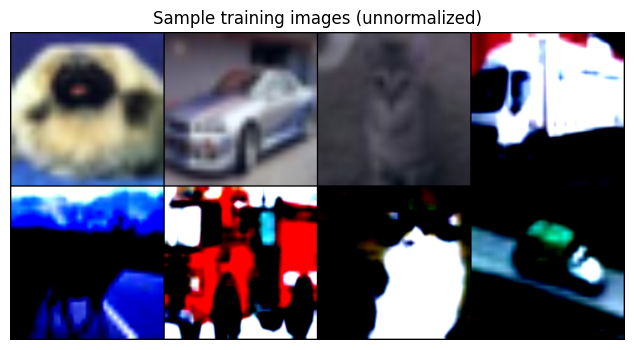

In [ ]:
# visualizing a batch
def unnormalize(img_tensor):
    img = img_tensor.clone().cpu()
    for t, m, s in zip(img, IMAGENET_MEAN, IMAGENET_STD):
        t.mul_(s).add_(m)
    return img

# get one batch
images, labels = next(iter(train_loader))
print("Raw batch shapes:", images.shape, labels.shape)

# show a grid of first 8 images
grid = vutils.make_grid(unnormalize(images[:8]), nrow=4, padding=2)
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.title("Sample training images (unnormalized)")
plt.show()

## Why resize CIFAR-10 to 227?
AlexNet expects 227×227 inputs; for testing the architecture and training loop we upsample CIFAR-10 images. This is fine for pipeline correctness but not for final performance comparison to ImageNet-trained AlexNet.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

print("Loss function and optimizer initialized.")

Loss function and optimizer initialized.


In [ ]:
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # --- Training phase ---
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)

    # --- Validation phase ---
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = 100. * val_correct / val_total
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print("Training completed.")

Epoch [1/10] Train Loss: 2.6898, Train Acc: 9.92% | Val Loss: 2.3270, Val Acc: 10.00%
Epoch [2/10] Train Loss: 2.3339, Train Acc: 10.07% | Val Loss: 2.3302, Val Acc: 10.00%
Epoch [3/10] Train Loss: 2.3285, Train Acc: 10.00% | Val Loss: 2.3095, Val Acc: 10.00%
Epoch [4/10] Train Loss: 2.3209, Train Acc: 10.18% | Val Loss: 2.3250, Val Acc: 10.00%
Epoch [5/10] Train Loss: 2.3233, Train Acc: 10.14% | Val Loss: 2.3288, Val Acc: 10.00%
Epoch [6/10] Train Loss: 2.3195, Train Acc: 9.92% | Val Loss: 2.3121, Val Acc: 10.00%
Epoch [7/10] Train Loss: 2.3189, Train Acc: 10.06% | Val Loss: 2.3232, Val Acc: 10.00%
Epoch [8/10] Train Loss: 2.3176, Train Acc: 10.02% | Val Loss: 2.3259, Val Acc: 10.00%
Epoch [9/10] Train Loss: 2.3182, Train Acc: 9.69% | Val Loss: 2.3081, Val Acc: 10.00%
Epoch [10/10] Train Loss: 2.3153, Train Acc: 10.20% | Val Loss: 2.3080, Val Acc: 10.00%
Training completed.


In [ ]:
from torch.optim.lr_scheduler import StepLR

# Reinitialize optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# StepLR: decreases LR by gamma every 'step_size' epochs
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step()  # 🔹 Update LR after each epoch

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"LR: {scheduler.get_last_lr()[0]:.5f}, "
          f"Train Loss: {running_loss/len(train_loader.dataset):.4f}, "
          f"Train Acc: {100.*correct/total:.2f}%")

print('Training with LR scheduling completed.')

Epoch [1/10], LR: 0.01000, Train Loss: 2.3157, Train Acc: 10.06%
Epoch [2/10], LR: 0.01000, Train Loss: 2.3157, Train Acc: 9.94%
Epoch [3/10], LR: 0.01000, Train Loss: 2.3168, Train Acc: 9.93%
Epoch [4/10], LR: 0.01000, Train Loss: 2.3144, Train Acc: 10.15%
Epoch [5/10], LR: 0.00100, Train Loss: 2.3153, Train Acc: 9.87%
Epoch [6/10], LR: 0.00100, Train Loss: 2.3046, Train Acc: 10.01%
Epoch [7/10], LR: 0.00100, Train Loss: 2.3043, Train Acc: 9.73%
Epoch [8/10], LR: 0.00100, Train Loss: 2.3045, Train Acc: 9.98%
Epoch [9/10], LR: 0.00100, Train Loss: 2.3045, Train Acc: 10.04%
Epoch [10/10], LR: 0.00010, Train Loss: 2.3045, Train Acc: 9.76%
Training with LR scheduling completed.


In [ ]:
# Save checkpoint
torch.save(model.state_dict(), "alexnet_paper_repro.pth")
print("Model saved as alexnet_paper_repro.pth")

# Load checkpoint (for verification)
loaded_model = AlexNetPaper(num_classes=1000).to(device)
loaded_model.load_state_dict(torch.load("alexnet_paper_repro.pth"))
print("Model loaded successfully and ready for inference.")

Model saved as alexnet_paper_repro.pth
Model loaded successfully and ready for inference.


In [ ]:
# Create test dataset and dataloader (for CIFAR-10)
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Use same normalization and resizing as training data
transform_test = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Test DataLoader created successfully.")

Test DataLoader created successfully.


In [ ]:
# model eval on test data
model.eval()
test_correct, test_total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_acc = 100. * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 10.00%


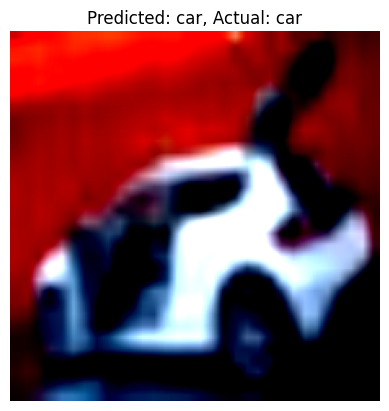

Predicted Label Index: 1, Actual Label Index: 1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# CIFAR-10 class labels
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Get one batch from the test_loader
dataiter = iter(test_loader)
images, labels = next(dataiter)


img_index = 6
img = images[img_index].to(device)
true_label = labels[img_index].item()

# Model inference
model.eval()
with torch.no_grad():
    output = model(img.unsqueeze(0))  # add batch dimension (1, 3, 227, 227)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()

# Display the image
plt.imshow(np.transpose(images[img_index].cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
plt.title(f'Predicted: {classes[predicted_label]}, Actual: {classes[true_label]}')
plt.axis('off')
plt.show()

# Print numeric labels for clarity
print(f"Predicted Label Index: {predicted_label}, Actual Label Index: {true_label}")